In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model'
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
# Creating an inspector to explore the columns
inspector = inspect(engine)

# Exploratory Climate Analysis

#### Inspecting the columns within the two tables


In [11]:
# Columns in the Measurement Table
Measurement_Columns = inspector.get_columns('Measurement')

# For loop to print the columns
for column_measure in Measurement_Columns:
    print(column_measure['name'], column_measure['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Columns in the Station Table
Station_Columns = inspector.get_columns('Station')

# For loop to print the columns
for column_station in Station_Columns:
    print(column_station['name'], column_station['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
# Determining the Entire Timeframe
total_time_frame = session.query(func.count(Measurement.date)).all()
total_time_frame[0]

(19550)

In [14]:
# Determining the Starting Date
start_date = session.query(Measurement.date).\
    order_by(Measurement.date).\
        first()

In [15]:
# Determining the Last Date
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
        first()

In [16]:
# Start and Finish Date of Record Keeping
print(f' The Starting Date is {start_date[0]} and the Last Date is {last_date[0]}')

 The Starting Date is 2010-01-01 and the Last Date is 2017-08-23


In [17]:
# Obtaining the Last Twelve Months of Precipitation
last_date_dt = dt.datetime.strptime(last_date[0],'%Y-%m-%d')


In [18]:
# Calculate the date 1 year ago from the last data point in the database - This will assist in obtaining all the data from this timepoint
query_date = dt.date(last_date_dt.year -1, last_date_dt.month, last_date_dt.day)
query_date

datetime.date(2016, 8, 23)

In [19]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]

precipitation_query = session.query(*sel).filter(Measurement.date >= query_date).all()

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
twelve_month_prcp = pd.DataFrame(precipitation_query, columns=['Date', 'Precipitation'])

twelve_month_prcp.set_index('Date', inplace=True)
twelve_month_prcp.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [21]:
# Sort the dataframe by date
twelve_month_prcp = twelve_month_prcp.sort_index(ascending=True)
twelve_month_prcp

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [22]:
# Removing the NaN values
twelve_month_prcp = twelve_month_prcp.dropna(how='any')
twelve_month_prcp

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


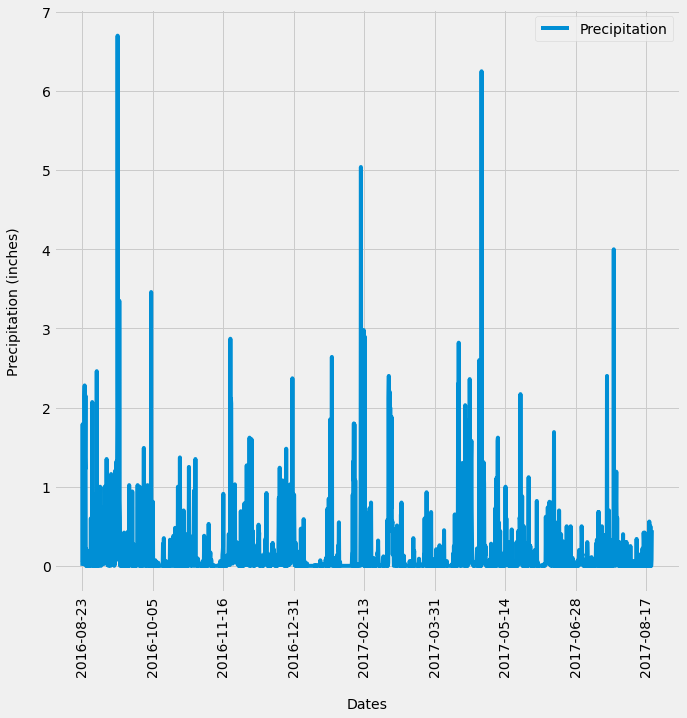

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
twelve_month_prcp.plot(rot=90, figsize=(10,10))
plt.legend(loc='upper right')
plt.ylabel('Precipitation (inches)\n',fontsize=14)
plt.xlabel('\nDates', fontsize=14)
plt.savefig('../Images/precipitation.png')
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics_precipitation = twelve_month_prcp.describe()

print(f'The Summary Statistics for Precipitation are:\n\n{summary_statistics_precipitation}')

The Summary Statistics for Precipitation are:

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.count(Station.station)).all()

for c in stations_count:
    print(f'The total number of stations in the dataset is {c[0]} Stations')



The total number of stations in the dataset is 9 Stations


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()


In [27]:
# List the stations and the counts in descending order.
for asc in active_station_count:
    print((f'Station ID - {asc[0]}| Count = {asc[1]}\n'))
    

Station ID - USC00519281| Count = 2772

Station ID - USC00519397| Count = 2724

Station ID - USC00513117| Count = 2709

Station ID - USC00519523| Count = 2669

Station ID - USC00516128| Count = 2612

Station ID - USC00514830| Count = 2202

Station ID - USC00511918| Count = 1979

Station ID - USC00517948| Count = 1372

Station ID - USC00518838| Count = 511



In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?

sel1 = [func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)]

active_station_analysis = session.query(*sel1).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()


print(f'The Lowest Recorded Temperature is {active_station_analysis[0]}\n\nThe Maximum Recorded Temperature is {active_station_analysis[1]}\n\nThe Average Temperature for Station {max(active_station_count)[0]} is {round(active_station_analysis[2],2)}')

The Lowest Recorded Temperature is 54.0

The Maximum Recorded Temperature is 85.0

The Average Temperature for Station USC00519523 is 71.66


In [29]:
# Choose the station with the highest number of temperature observations.
USC00519281

In [30]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram



In [31]:
# Converting Query to a Pandas Dataframe


# Plotting the Histogram


## Bonus Challenge Assignment

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [39]:
# Plot the daily normals as an area plot with `stacked=False`
